In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

import lazypredict
from lazypredict.Supervised import LazyRegressor

import statsmodels.api as sm

from statsmodels.tsa.seasonal import STL
from matplotlib import pyplot as plt, rc_context, rc
from fbprophet import Prophet

In [83]:
df = pd.read_csv('data/rf_incendiosflorestais_focoscalor_estados_1998-2017.csv', sep="\t", encoding ="iso-8859-1")

#renaming the columns
df.rename(columns={'Ano': 'year', 'Estado': 'state', 'Mês': 'month', 'Número': 'number', 'Período':'period'}, inplace=True)
df

,year,state,month,number,period
0,1998,Acre,Janeiro,0.00,01/01/1998
1,1999,Acre,Janeiro,0.00,01/01/1999
2,2000,Acre,Janeiro,0.00,01/01/2000
3,2001,Acre,Janeiro,0.00,01/01/2001
4,2002,Acre,Janeiro,0.00,01/01/2002
...,...,...,...,...,...
6449,2012,Tocantins,Dezembro,128.00,01/01/2012
6450,2013,Tocantins,Dezembro,85.00,01/01/2013
6451,2014,Tocantins,Dezembro,223.00,01/01/2014
6452,2015,Tocantins,Dezembro,373.00,01/01/2015


In [84]:
df.dtypes

year        int64
state      object
month      object
number    float64
period     object
dtype: object

The column date is wrong, for the month, therefore it's better to drop it and work with the other ones.

In [86]:
df.drop(columns=['period'], inplace=True)

The name of the months are written in Brazilian-Portuguese, these will be changed to the corresponding numbers to compose the datetime column.

In [87]:
df.month.unique()

array(['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho',
       'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro'],
      dtype=object)

In [88]:
df.replace({'Janeiro': '01', 'Fevereiro': '02', 'Março': '03', 'Abril': '04',
            'Maio': '05', 'Junho': '06', 'Julho': '07', 'Agosto': '08',
            'Setembro': '09', 'Outubro': '10', 'Novembro': '11', 'Dezembro': '12'}, inplace=True)

In [89]:
df.month.unique()

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'], dtype=object)

In [90]:
df['date'] = df['year'].astype('str') + df['month']
df

,year,state,month,number,date
0,1998,Acre,01,0.00,199801
1,1999,Acre,01,0.00,199901
2,2000,Acre,01,0.00,200001
3,2001,Acre,01,0.00,200101
4,2002,Acre,01,0.00,200201
...,...,...,...,...,...
6449,2012,Tocantins,12,128.00,201212
6450,2013,Tocantins,12,85.00,201312
6451,2014,Tocantins,12,223.00,201412
6452,2015,Tocantins,12,373.00,201512


In [91]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m')

With the date columns there's no use for separate columns for year and month, those will then be dropped.

In [92]:
df.drop(columns=['year', 'month'], inplace=True)

In [93]:
df

,state,number,date
0,Acre,0.00,1998-01-01
1,Acre,0.00,1999-01-01
2,Acre,0.00,2000-01-01
3,Acre,0.00,2001-01-01
4,Acre,0.00,2002-01-01
...,...,...,...
6449,Tocantins,128.00,2012-12-01
6450,Tocantins,85.00,2013-12-01
6451,Tocantins,223.00,2014-12-01
6452,Tocantins,373.00,2015-12-01


## All states

In [94]:
pd.pivot_table(df, values='number', index=['state', 'date'])

number
state     date              
Acre      1998-01-01    0.00
          1998-02-01    0.00
          1998-03-01    0.00
          1998-04-01    0.00
          1998-05-01    0.00
...                      ...
Tocantins 2017-07-01    2.40
          2017-08-01    3.54
          2017-09-01   10.74
          2017-10-01    2.97
          2017-11-01  434.00

[6453 rows x 1 columns]

Text(0.5, 1.0, 'States with more fires')

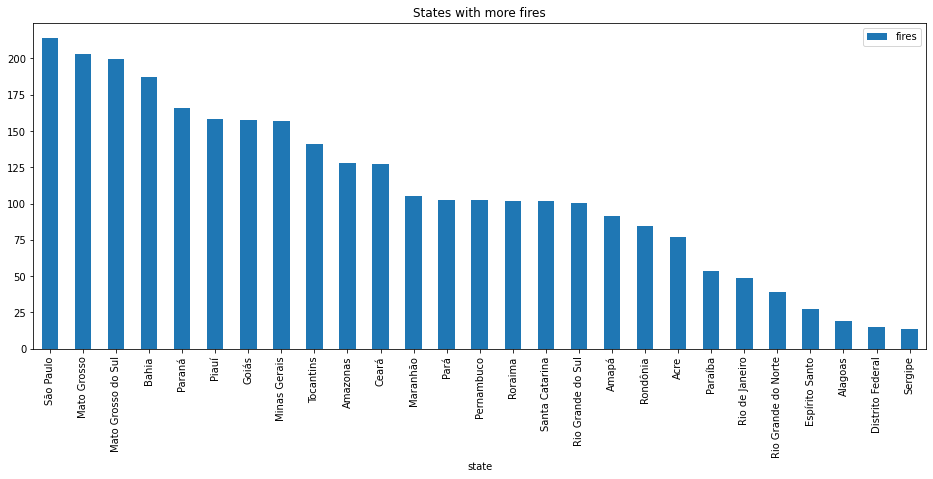

In [95]:
df_state = pd.pivot_table(df, values='number', index=['state']).rename(columns={'number': 'fires'})
df_state.sort_values('fires', ascending=False).plot.bar(figsize=(16,6)).set_title('States with more fires')

In [15]:
# sort by 'state' and then 'date'
df.sort_values(['state', 'date'], inplace=True)

Create a dataframe that sums the fires over all states.

In [63]:
df_sum = df.drop(columns=['state']).set_index('date').sum(level='date')
#pd.set_option('display.max_rows', len(df_sum))
df_sum

,number
date,
1998-01-01,0.00
1998-02-01,0.00
1998-03-01,0.00
1998-04-01,0.00
1998-05-01,0.00
...,...
2017-07-01,5930.00
2017-08-01,4120.41
2017-09-01,2779.32


<AxesSubplot:title={'center':'Fires through all states'}, xlabel='date'>

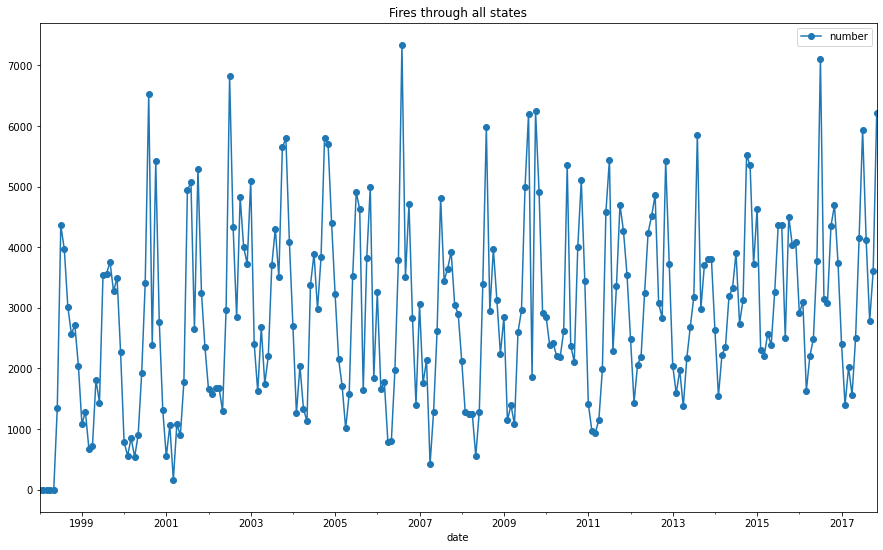

In [69]:
df_sum.plot(figsize=(15,9), style='o-', title='Fires through all states')

In [21]:
df_sum['date'] = df_sum.index 
df_sum.date.dt.month

date
1998-01-01     1
1998-02-01     2
1998-03-01     3
1998-04-01     4
1998-05-01     5
              ..
2017-07-01     7
2017-08-01     8
2017-09-01     9
2017-10-01    10
2017-11-01    11
Name: date, Length: 239, dtype: int64

<AxesSubplot:xlabel='date', ylabel='number'>

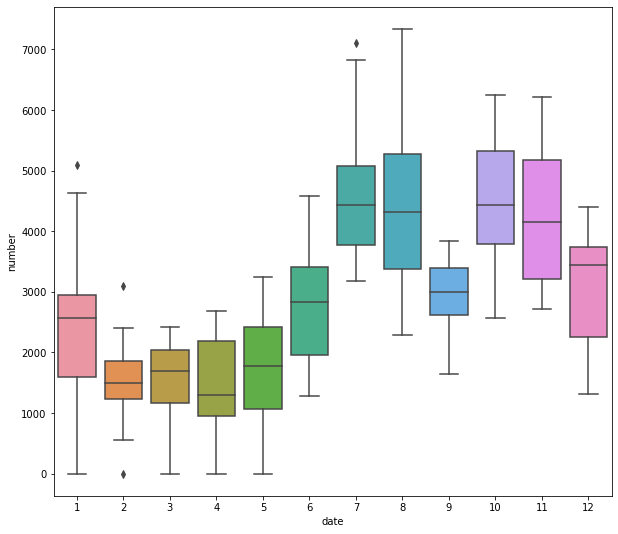

In [22]:
sns.boxplot(x=df_sum.date.dt.month, y=df_sum.number)

Decomposing the time series with the [STL](https://otexts.com/fpp2/stl.html) (Seasonal and Trend decomposition using Loess) method.

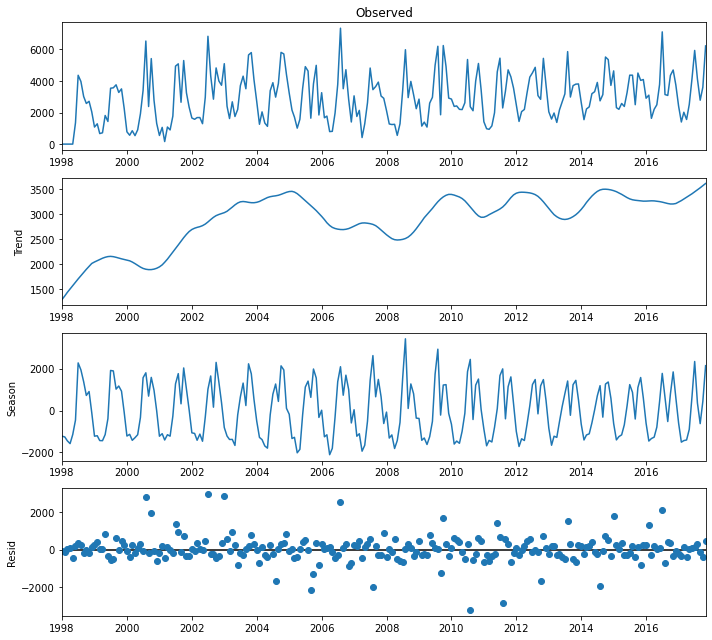

In [71]:
plt.rcParams.update({'figure.figsize':(10,9)})
stl = STL(df_sum, robust=True)
res = stl.fit()
fig = res.plot()

We can see a clear positive trend.

---

## The Amazon rainforest

The Amazon rainforest has about 5 million square kilometers, It occupys 60% of the Brazillian territory and is composed by the following states: 
<br>
*Acre, Amapá, Amazonas, Mato Grosso, Maranhão, Pará, Roraima, Rondônia e Tocantins*
<br>
[Source](https://educacao.uol.com.br/disciplinas/ciencias/floresta-amazonica-a-maior-floresta-tropical-do-mundo.htm)

In [23]:
df.state.unique()

array(['Acre', 'Alagoas', 'Amapa', 'Amazonas', 'Bahia', 'Ceara',
       'Distrito Federal', 'Espirito Santo', 'Goias', 'Maranhao',
       'Mato Grosso', 'Minas Gerais', 'Paraiba', 'Pará', 'Pernambuco',
       'Piau', 'Rio', 'Rondonia', 'Roraima', 'Santa Catarina',
       'Sao Paulo', 'Sergipe', 'Tocantins'], dtype=object)

In [24]:
#state_grp.getdf.drop(columns=['state']).set_index('date').sum(level='date')
#df_amazon = state_grp.get_group('Amazonas')#.drop(columns=['state']).set_index('date')

state_grp = df.groupby(['state'])

amazon_states = ['Amapa', 'Amazonas', 'Mato Grosso', 'Maranhao', 'Pará', 'Roraima', 'Rondonia', 'Tocantins']

df_amazon = pd.DataFrame()

for state in amazon_states:
    df_amazon = pd.concat([df_amazon, state_grp.get_group(state)])

In [25]:
df_amazon = df_amazon.drop(columns=['state']).set_index('date').sum(level='date')

In [26]:
# Renaming columns to comply with Prophet requirements.

df_amazon.reset_index(inplace=True)
df_amazon.rename(columns={'date':'ds', 'number':'y'}, inplace=True)
df_amazon

,ds,y
0,1998-01-01,0.00
1,1998-02-01,0.00
2,1998-03-01,0.00
3,1998-04-01,0.00
4,1998-05-01,0.00
...,...,...
234,2017-07-01,23.00
235,2017-08-01,105.69
236,2017-09-01,225.17
237,2017-10-01,1334.18


<AxesSubplot:xlabel='ds'>

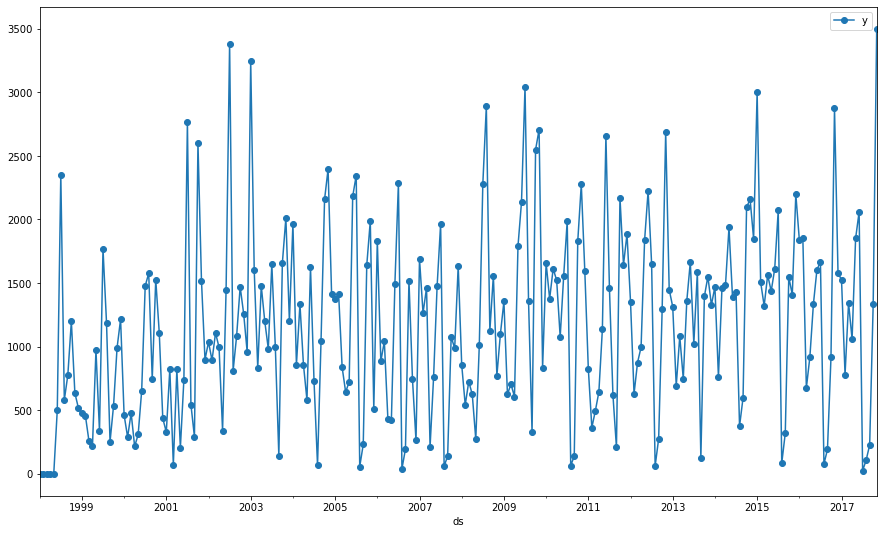

In [27]:
df_amazon.plot(x='ds', y='y', figsize=(15,9), style='o-')

In [30]:
df_amazon.dtypes

ds    datetime64[ns]
y            float64
dtype: object

In [31]:
p = Prophet()
p.fit(df_amazon)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
forecast = p.predict(df_amazon)

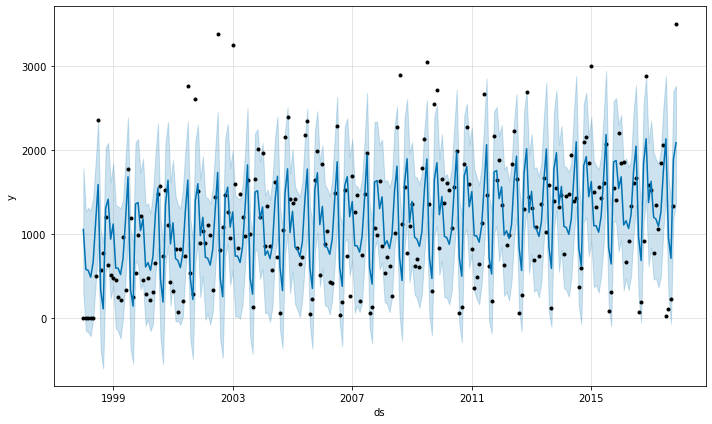

In [33]:
fig1 = p.plot(forecast)

In [34]:
#future = p.make_future_dataframe(periods=len(df_amazon_test), freq='M')
future = p.make_future_dataframe(periods=56, freq='M')
forecast = p.predict(future)

In [35]:
help(Prophet.predict)

Help on function predict in module fbprophet.forecaster:

predict(self, df=None)
    Predict using the prophet model.
    
    Parameters
    ----------
    df: pd.DataFrame with dates for predictions (column ds), and capacity
        (column cap) if logistic growth. If not provided, predictions are
        made on the history.
    
    Returns
    -------
    A pd.DataFrame with the forecast components.



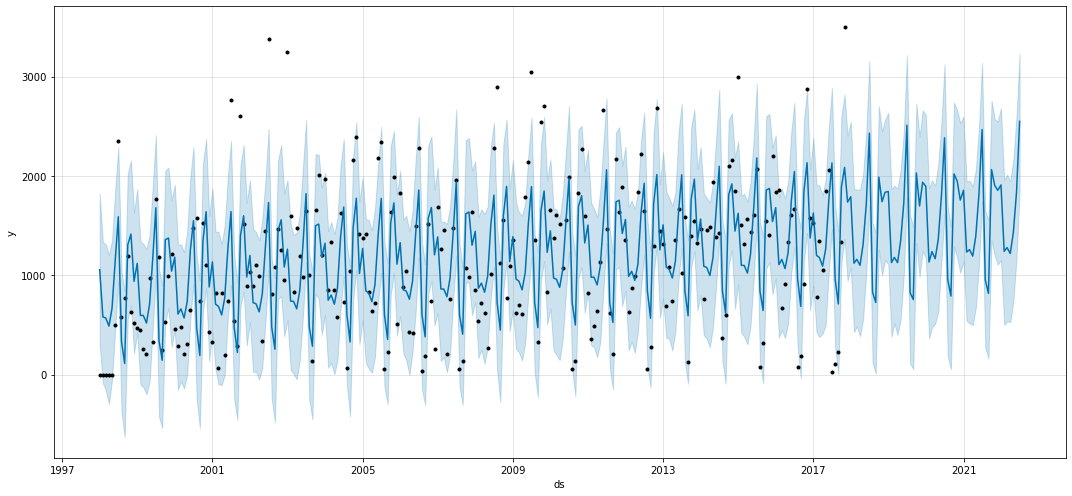

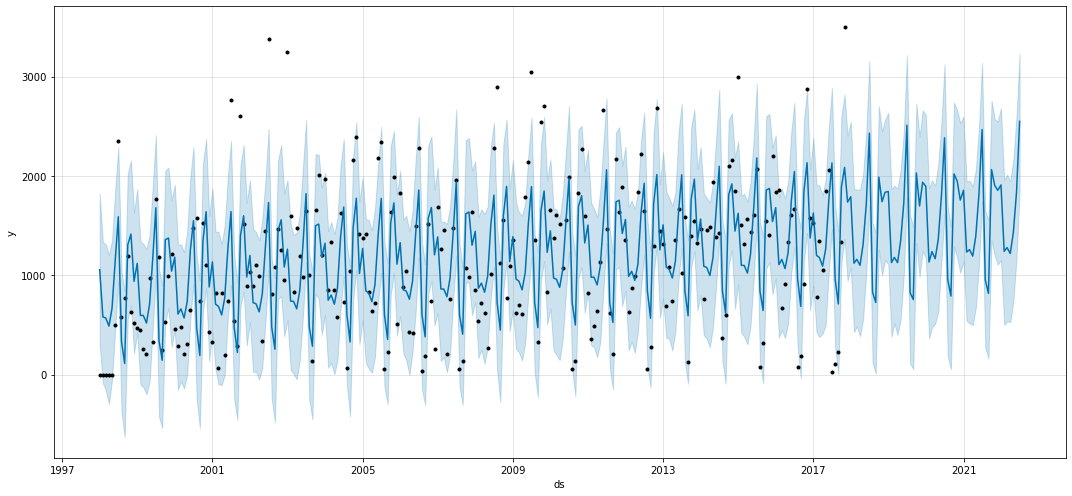

In [36]:
p.plot(forecast, figsize=(15,7), uncertainty=0.89)

In [37]:
df_amazon

,ds,y
0,1998-01-01,0.00
1,1998-02-01,0.00
2,1998-03-01,0.00
3,1998-04-01,0.00
4,1998-05-01,0.00
...,...,...
234,2017-07-01,23.00
235,2017-08-01,105.69
236,2017-09-01,225.17
237,2017-10-01,1334.18


In [38]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1998-01-01,813.10,295.58,1823.33,813.10,813.10,243.55,243.55,243.55,243.55,243.55,243.55,0.00,0.00,0.00,1056.65
1,1998-02-01,816.15,-85.09,1334.61,816.15,816.15,-234.72,-234.72,-234.72,-234.72,-234.72,-234.72,0.00,0.00,0.00,581.43
2,1998-03-01,818.90,-156.57,1310.97,818.90,818.90,-248.53,-248.53,-248.53,-248.53,-248.53,-248.53,0.00,0.00,0.00,570.37
3,1998-04-01,821.95,-294.08,1207.96,821.95,821.95,-332.96,-332.96,-332.96,-332.96,-332.96,-332.96,0.00,0.00,0.00,488.99
4,1998-05-01,824.89,-49.59,1354.58,824.89,824.89,-155.71,-155.71,-155.71,-155.71,-155.71,-155.71,0.00,0.00,0.00,669.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,2022-02-28,1566.33,537.09,2014.43,1564.04,1568.92,-286.77,-286.77,-286.77,-286.77,-286.77,-286.77,0.00,0.00,0.00,1279.56
291,2022-03-31,1568.85,530.16,1946.19,1566.50,1571.52,-348.92,-348.92,-348.92,-348.92,-348.92,-348.92,0.00,0.00,0.00,1219.93
292,2022-04-30,1571.30,735.68,2160.77,1568.90,1574.05,-140.92,-140.92,-140.92,-140.92,-140.92,-140.92,0.00,0.00,0.00,1430.37
293,2022-05-31,1573.82,1170.34,2601.64,1571.34,1576.65,262.32,262.32,262.32,262.32,262.32,262.32,0.00,0.00,0.00,1836.14


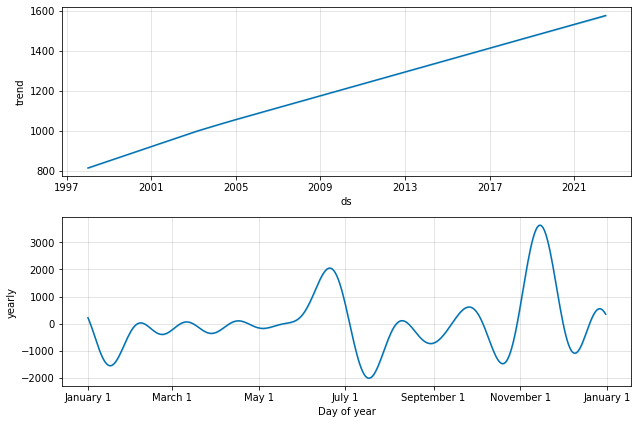

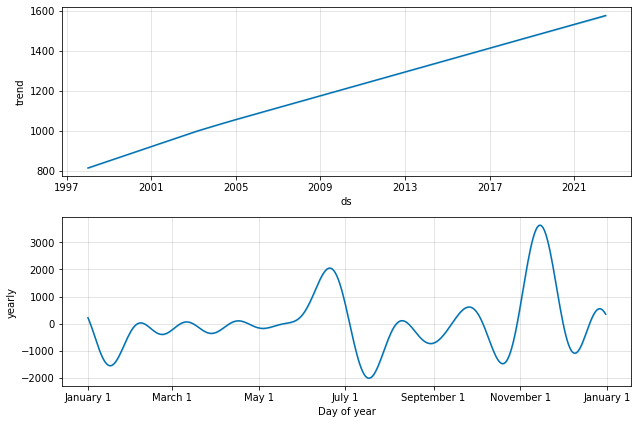

In [39]:
p.plot_components(forecast)

We can see a clear positive trend. Also the yearly seasonality show peaks on the end of June and mid November.

In [40]:
from fbprophet.diagnostics import cross_validation

df_cv = cross_validation(p, initial='730 days', period='180 days', horizon = '365 days')

INFO:fbprophet:Making 35 forecasts with cutoffs between 2000-01-30 00:00:00 and 2016-11-01 00:00:00


  0%|          | 0/35 [00:00<?, ?it/s]

INFO:fbprophet:n_changepoints greater than number of observations. Using 19.
INFO:fbprophet:n_changepoints greater than number of observations. Using 23.


---
---